In [14]:
import numpy as np
from scipy import integrate as integ
from scipy import signal as signal
import sympy as sp
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets
from tqdm import tqdm
###
from turing_model import TuringModel as tm
from numba import jit

In [101]:
@jit
def slow(var, t):
    # fill var
    N_a = var[0]
    N_b = var[1]
    A_a = var[2]
    A_b = var[3]
    H_1a = var[4]
    H_1b = var[5]
    H_2a = var[6]
    H_2b = var[7]
    d_H1a = var[8]
    d_H2a = var[9]
    d_H1b = var[10]
    d_H2b = var[11]
    H1_loss = var[12]
    H2_loss = var[13]

    # growth rate of autotrophs
    r_a = (r_max * N_a) / (N_h + N_a)
    r_b = (r_max * N_b) / (N_h + N_b)

    # growth rate of competitors
    g_1a = (a_1 * A_a) / (1 + a_1 * h * A_a)
    g_1b = (a_1 * A_b) / (1 + a_1 * h * A_b)
    g_2a = (a_2 * A_a) / (1 + a_2 * h * A_a)
    g_2b = (a_2 * A_b) / (1 + a_2 * h * A_b)

    # inflection points
    x_01 = D / (a_1 * (e - h * D))
    x_02 = D / (a_2 * (e - h * D))
    
    # dispersal rates of competitors
    d_H1a = d_Hmax1 / (1 + np.exp(k_1 * (A_a - x_01)))
    d_H1b = d_Hmax1 / (1 + np.exp(k_1 * (A_b - x_01)))
    d_H2a = d_Hmax2 / (1 + np.exp(k_2 * (A_a - x_02)))
    d_H2b = d_Hmax2 / (1 + np.exp(k_2 * (A_b - x_02)))

    # change of nutrients
    dN_a = D * (S - N_a) - r_a * A_a + d_N * (N_b - N_a)
    dN_b = D * (S - N_b) - r_b * A_b + d_N * (N_a - N_b)

    # change of autotrophs
    dA_a = r_a * A_a - ((g_1a * H_1a) + (g_2a * H_2a)) - D * A_a + d_A * (A_b - A_a)
    dA_b = r_b * A_b - ((g_1b * H_1b) + (g_2b * H_2b)) - D * A_b + d_A * (A_a - A_b)

    # change of competitors
    dH_1a = e * g_1a * H_1a - D * H_1a - d_H1a * H_1a + d_H1b * H_1b
    dH_1b = e * g_1b * H_1b - D * H_1b - d_H1b * H_1b + d_H1a * H_1a
    dH_2a = e * g_2a * H_2a - D * H_2a - d_H2a * H_2a + d_H2b * H_2b
    dH_2b = e * g_2b * H_2b - D * H_2b - d_H2b * H_2b + d_H2a * H_2a

    H1_loss = d_H1a-(d_H1a * dH_1a)/(1 + np.exp(k_1 * (A_a - x_01)))
    H2_loss = d_H2a-(d_H2a * dH_2a)/(1 + np.exp(k_2 * (A_a - x_02)))

    return(dN_a, dN_b, dA_a, dA_b, dH_1a, dH_1b, dH_2a, dH_2b, d_H1a, d_H2a, d_H1b, d_H2b, H1_loss, H2_loss)

C:\Users\rmjar\AppData\Local\Temp\ipykernel_19292\3404625646.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [102]:
# var
var = []

# set parameters
S = 4.8 # Nutrient supply concentration
D = 0.3 # Dilution rate
N_h = 1.5 # half saturation constant for nutrient uptake
r_max = 0.7 # growth rate of autotroph
h = 0.53 # handling time
e = 0.33 # conversion efficiency of competitor
d_N = 1 # Dispersal rate of nutrients 
d_A = 0.001 # dispersal rate of autotrophs

# competitiveness 
a_1 = 1 # attack rate of competitor 1 
a_2 = 1 # attack rate of competitor 2 

# adaptability
k_1 = 0 # dispersal adaptability of competitor 1 
k_2 = 2 # dispersal adaptability of competitor 2 
        # 0 = random dispersal, 2 = adaptive dispersal

# dispersal speed 
d_Hmax1 = 0.0001 # maximal dispersal rates of competitor 1  
d_Hmax2 = 0.0001 # maximal dispersal rates of competitor 2  

In [103]:
t_end = 1000#0 #4000  # 100000
number_steps = 100#00 #2000  # 25000
t = np.linspace(0, t_end, number_steps)
# dispersal adaptability
k_1 = 5
k_2 = 0
k_1_range = np.geomspace(0.0001, 10, 100)
k_2_range = np.geomspace(0.0001, 10, 100)
# maximum dispersal rate
d_Hmax1 = 10**-2
d_Hmax2 = 10**-2
d_Hmax1_range = np.logspace(-3, 1, 25)
d_Hmax2_range = d_Hmax1_range

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]
var = []
model = tm(var0, t, k_1, k_2, d_Hmax1, d_Hmax2)

H1x_extr = []
H1y_extr = []
H2x_extr = []
H2y_extr = []
H1_extr = []
H2_extr = []
num_extr = 20

In [104]:
# Save results
# results = np.zeros((len(d_Hmax1_range),len(d_Hmax2_range)))
density_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
mode_H1 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
mode_H2 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensity_Ax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensity_Ay = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensityOsc_Ax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensityOsc_Ay = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H1xmax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H2xmax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H1xmin = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H2xmin = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
total_H1 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
total_H2 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
invasion = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
# save initial values in an array
initials = np.array(var0)

In [78]:
# Integrating over two variable parameters
# change for new method with equation wrapper

var = []

i = 0
j = 0

for d_Hmax2 in tqdm(d_Hmax2_range):
    j = 0
    for d_Hmax1 in d_Hmax1_range:
        var = integ.odeint(slow, var0, t)

        # results[i,j] = ...
        density_H1x[i, j] = var[-1, 4]
        density_H1y[i, j] = var[-1, 5]
        density_H2x[i, j] = var[-1, 6]
        density_H2y[i, j] = var[-1, 7]

        checkOsc_H1x[i, j] = np.var(var[-200:-1, 4])
        checkOsc_H1y[i, j] = np.var(var[-200:-1, 5])
        checkOsc_H2x[i, j] = np.var(var[-200:-1, 6])
        checkOsc_H2y[i, j] = np.var(var[-200:-1, 7])

        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])
        meandensity_H1y[i, j] = np.mean(var[-200:-1, 5])
        meandensity_H2x[i, j] = np.mean(var[-200:-1, 6])
        meandensity_H2y[i, j] = np.mean(var[-200:-1, 7])

        autodensity_Ax[i, j] = np.mean(var[-200:-1, 2])
        autodensity_Ay[i, j] = np.mean(var[-200:-1, 3])

        autodensityOsc_Ax[i, j] = np.var(var[-200:-1, 2])
        autodensityOsc_Ay[i, j] = np.var(var[-200:-1, 3])

        H1xmax[i, j] = max(var[-200:-1, 4])
        H2xmax[i, j] = max(var[-200:-1, 6])

        j += 1
    i += 1

100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


In [105]:
# Set up parameters and arrays
t_end = 1000
number_steps = 100
t = np.linspace(0, t_end, number_steps)

k_1_range = np.geomspace(0.0001, 10, 100)
k_2_range = np.geomspace(0.0001, 10, 100)
d_Hmax1_range = np.logspace(-3, 1, 25)
d_Hmax2_range = d_Hmax1_range

# Initialize arrays to store results
density_H1x = np.zeros((len(d_Hmax2_range), len(d_Hmax1_range)))

# Initial conditions
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]

for i, d_Hmax2 in enumerate(tqdm(d_Hmax2_range)):
    for j, d_Hmax1 in enumerate(d_Hmax1_range):

        var = integ.odeint(slow, var0, t)

        # Store results for iteration
        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])



100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


In [107]:
meandensity_H1x

array([[0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343],
       [0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343],
       [0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.

<Axes: >

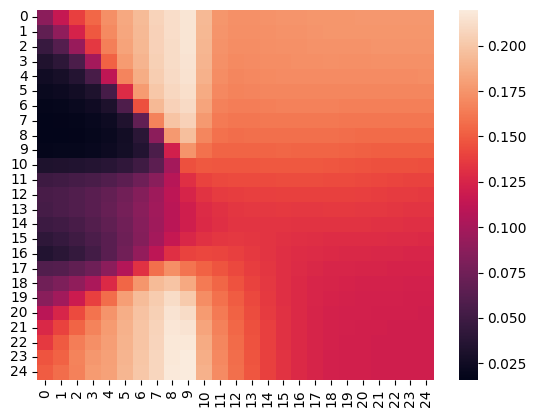

In [100]:
# Random dispersal scenario
# Heatmap: Iterating over dHmax1 and dHmax2 for k1 = k2 = 0.


sns.heatmap(meandensity_H1x)